<a href="https://colab.research.google.com/github/ssubbinn/ESAA-OB/blob/main/10%EC%A3%BC%EC%B0%A8_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 추천 시스템

추천 시스템의 유형

- 콘텐츠 기반 필터링
- 협업 필터링
  - 최근접 이웃
  - 잠재요인

최근에는 잠재요인 협업 필터링 기반의 추천 시스템 많이 씀




### 콘텐츠 기반 필터링 추천 시스템

- 사용자가 특정한 아이템을 매우 선호하는 경우, 그 아이템과 비슷한 콘텐츠를 가진 다른 아이템 추천

### 최근접 이웃 협업 필터링

협업 필터링 : 사용자가 아이템에 매긴 평점 정보나 상품 구매 이력과 같은 사용자 행동 양식만을 기반으로 추천을 수행하는 것

최근접 이웃, 잠재 요인 방식 모두 사용자-아이템 평점 행렬 데이터에만 의지해 추천 수행

- 행렬에서 행은 개별 사용자, 열은 개별 아이템, 데이터= 평점을 나타냄
- 평점 행렬은 많은 아이템을 열로 가지는 다차원 행렬, 사용자가 아이템에 대한 평점을 매기는 경우가 많지 않기 때문에 희소행렬 특성을 가짐

최근접 이웃 협업 필터링= 메모리 협업 필터링
1. 사용자 기반 : 당신과 비슷한 고객들이 다음 상품도 구매했습니다
- 유사도 높은 사용자끼리 서로 선호하는 아이템 추천

2. 아이템 기반 : 이 상품을 선택한 다른 고객들은 다음 상품도 구매했습니다
- 사용자들이 그 아이템을 좋아하는지/싫어하는지의 평가 척도가 유사한 아이템을 추천

-> 이게 정확도 더 높음

###잠재 요인 협업 필터링

잠재 요인 협업 필터링의 이해

: 사용자-아이템 평점 매트릭스 속에 숨어있는 잠재 요인을 추출해 추천 예측을 할 수 있게 하는 기법

행렬 분해 : 대규모 다차원 행렬을 SVD와 같은 차원 감소 기법으로 분해하는 과정에서 잠재 요인 추출

- 잠재 요인을 명확히 정의할 수는 없음

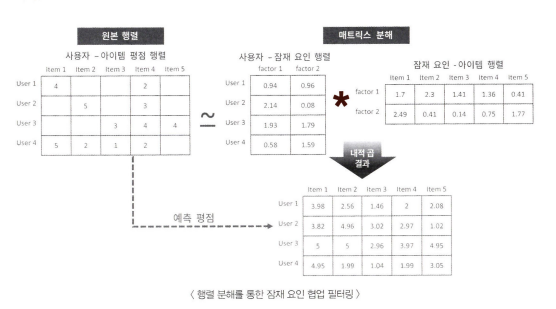

**행렬 분해의 이해**

행렬 분해: 다차원의 매트릭스를 저차원 매트릭스로 분해하는 기법. 대표적으로 SVD, NMF등 존재

ex) M개의 사용자 행과 N 개의 아이템 열을 가지 ㄴ평점 행렬 MXN 차원으로 구성. 행렬 분해를 통해 사용자-K 차원 잠재 요인 행렬 P와 K 차원 잠재 요인-아이템 행렬 Q.T로 분해 가능

즉 R=P*Q.T
- M은 총 사용자수
- N은 총 아이템수
- K는 잠재 요인의 차원 수
- R은 MXN 차원의 사용자-아이템 평점 행렬
- P는 사용자와 잠재 요인과의 관계 값을 가지는 MXK 차원의 사용자-잠재 요인 행렬
- Q는 아이템과 잠재요인과의 관계 값을 가지는 NXK 차원의 아이템-잠재 요인 행렬
- Q.T는 Q 매트릭스의 행과 열 값을 교환한 전치 행렬

R행렬을 P와 Q로 분해?
-> SVD 방식
- nan 없는 행렬에만 적용가능
- nan있을땐 ALS나 확률적 경사 하강법 이용해서 수행

**확률적 경사 하강법을 이용한 행렬 분해**

- P와 Q 행렬로 계산된 예측 R 행렬 값이 실제 R 행렬 값과 가장 최소의 오류를 가질 수 있도록 반복적인 비용함수 최적화를 통해 P와 Q를 유추

1. P와 Q를 임의의 값을 가진 행렬로 설정
2. P와 Q,T 값을 곱해 예측 R 행렬을 계싼하고 예측 R 행렬과 실제 R 행렬에 해당하는 오류 값 계산
3. 이 오류 값을 최소화할수 있도록 P,Q행렬을 적절한 값으로 가가각 업데이트
4. 만족할만한 오류 값을 가질 때까지 2,3번 작업을 반복하면서 P와 Q값을 업데이트해 근사화

L2규제 반영->SGD


In [1]:
import numpy as np

#원본 행렬 R 생성, 분해 행렬 P와 Q 초기화, 잠재요인 차원 K는 3으로 설정.
R=np.array([[4, np.NaN, np.NaN, 2, np.NaN],
            [np.NaN, 5, np.NaN, 3, 1],
            [np.NaN, np.NaN, 3, 4, 4],
            [5,2,1,2,np.NaN]])
num_users, num_items=R.shape
K=3

#P와 Q의 행렬 크기를 지정하고 정규 분포를 가진 임의의 값으로 입력
np.random.seed(1)
P=np.random.normal(scale=1./K, size=(num_users, K))
Q=np.random.normal(scale=1./K, size=(num_items, K))

In [2]:
# 실제 R 행렬과 예측 행렬의 오차를 구하는 함수 생성
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
  error=0
  #두개의 분해된 행렬 P와 Q.T의 내적으로 예측 R 행렬 생성
  full_pred_matrix=np.dot(P, Q.T)

  #실제 R 행렬에서 널이 아닌 값의 위치 인덱스를 추출해 실제 R 행렬롸 예측 행렬의 RMSE 추출
  x_non_zero_ind=[non_zero[0] for non_zero in non_zeros]
  y_non_zero_ind=[non_zero[1] for non_zero in non_zeros]
  R_non_zeros=R[x_non_zero_ind, y_non_zero_ind]
  full_pred_matrix_non_zeros=full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
  mse=mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
  rmse=np.sqrt(mse)

  return rmse

In [3]:
#R>0인 행과 열의 위치, 값을 non_zeros 리스트에 저장
non_zeros=[ (i, j, R[i, j]) for i in range(num_users) for j in range(num_items) if R[i, j]>0]
steps=1000
learning_rate=0.01
r_lambda=0.01

#SGD 기법으로 P와 Q 매트릭스를 계속 업데이트
for step in range(steps):
  for i, j, r in non_zeros:
    #실제 값과 예측 값의 차이인 오류 값 구함
    eij=r-np.dot(P[i, :], Q[j, :].T)
    #Regularization을 반영한 SGD 업데이트 공식 적용
    P[i, :]=P[i, :]+learning_rate*(eij*Q[j, :]-r_lambda*P[i, :])
    Q[j, :]=Q[j, :]+learning_rate*(eij*P[i, :]-r_lambda*Q[j, :])
  rmse=get_rmse(R, P, Q, non_zeros)
  if (step%50)==0:
    print('### iteration step : ', step, 'rmse : ', rmse)
     

### iteration step :  0 rmse :  3.2388050277987723
### iteration step :  50 rmse :  0.4876723101369648
### iteration step :  100 rmse :  0.1564340384819247
### iteration step :  150 rmse :  0.07455141311978046
### iteration step :  200 rmse :  0.04325226798579314
### iteration step :  250 rmse :  0.029248328780878973
### iteration step :  300 rmse :  0.022621116143829466
### iteration step :  350 rmse :  0.019493636196525135
### iteration step :  400 rmse :  0.018022719092132704
### iteration step :  450 rmse :  0.01731968595344266
### iteration step :  500 rmse :  0.016973657887570753
### iteration step :  550 rmse :  0.016796804595895633
### iteration step :  600 rmse :  0.01670132290188466
### iteration step :  650 rmse :  0.01664473691247669
### iteration step :  700 rmse :  0.016605910068210026
### iteration step :  750 rmse :  0.016574200475705
### iteration step :  800 rmse :  0.01654431582921597
### iteration step :  850 rmse :  0.01651375177473524
### iteration step :  900 rms

In [4]:
#분해된 P와 Q함수를 P*Q.T로 예측 행렬을 만들어서 출력
pred_matrix=np.dot(P, Q.T)
print('예측 행렬:\n', np.round(pred_matrix, 3))

예측 행렬:
 [[3.991 0.897 1.306 2.002 1.663]
 [6.696 4.978 0.979 2.981 1.003]
 [6.677 0.391 2.987 3.977 3.986]
 [4.968 2.005 1.006 2.017 1.14 ]]
